In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

plt.rcParams.update({
    "text.usetex": True,
    "figure.dpi": 120})

mpl.style.use("seaborn-deep")

## Generative process

In [4]:
def omega(dim, scale=1e-1):
    return np.random.normal(loc=0, scale=scale, size=dim)

In [5]:
# Set up simulation space
bins         = 10                       # Time bins
dt           = 0.01                     # Discretization interval
t            = np.arange(0, bins, dt)   # Time steps
T            = len(t)                   # Number of time steps

# Object dimensions
c            = 1                        # Dimension of x^* (external state)
d            = 1                        # Dimension of y (observation)

# Generating functions
def fe(x, theta_x=10):
    return theta_x - x

def ge(x, theta_y=3):
    return x - theta_y

# Empty arrays
x = np.zeros((T, c))
y = np.zeros((T, d))

x[0] = 5          + omega(c)
y[0] = ge(x=x[0]) + omega(d)

In [6]:
def env_step(t):
    x[t+1] = x[t] + dt * fe(x=x[t]) + np.random.normal(loc=0, scale=1e-1)
    y[t+1] = ge(x=x[t+1])           + np.random.normal(loc=0, scale=1e-1)
    return x, y
    
def run_env():
    for t in range(T-1):
        x, y = env_step(t)
        
    return x, y

x, y = run_env()

<Figure size 720x480 with 0 Axes>

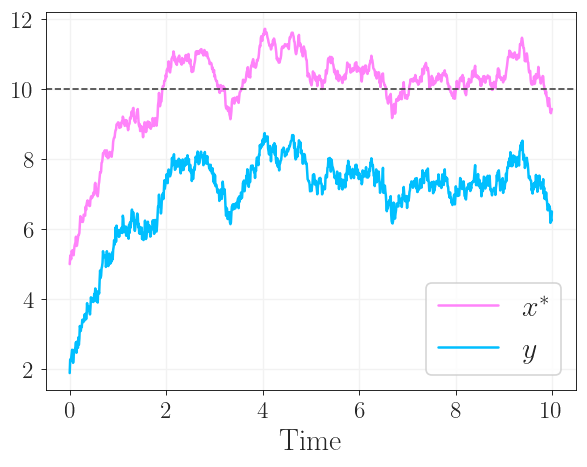

In [124]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, ax = plt.subplots(1,1, facecolor=(1,1,1), figsize=(5,4))

ax.plot(t, x, c="#FF83FA", label=r"$x^*$")
ax.plot(t, y, c="#00BFFF", label=r"$y$")
ax.axhline(y=10, lw=1, ls="--", c="#424242")

# Plot labels
ax.set_xlabel(r"$\textrm{Time}$", fontsize=18)

# Subplot legends
ax.legend(frameon=True, fontsize=18)

# Cosmetic changes and axes ranges
ax.axes.grid(which="major", axis="both", c="#f2f2f2")
plt.setp(ax.spines.values(), color="black", linewidth=0.5)
ax.tick_params(
    labelsize=14,
    axis='both',          
    which='major',      
    bottom=True,
    left=True,
    color="black",
    width=0.5,
    length=3)

fig.tight_layout()

In [125]:
fig.savefig("../graphics_v2/6a_gp.pdf", bbox_inches="tight", dpi=300)

## Generative model

In [12]:
# Agent's generating function for x
def gm(mu_x):
    return ge(mu_x)

# Derivative of agent's generating function for y 
def dg_dmu(mu_x):
    return 1

# Derivative of agent's generating function for mu_x 
def df_dmu(mu_x):
    return -1

# Agent's generating function for mu_x
def fm(mu_x):
    return fe(mu_x)

# Variational free energy
def F(e_x, e_y, p_x, p_y):
    return 0.5 * (p_y * e_y**2 + p_x * e_x**2 + np.log(p_y**-1 * p_x**-1)) 

# Partial derivative of VFE with respect to mu_x
def dvfe_dmx(mu_x, e_x, e_y, p_x, p_y):
    return p_y * e_y * dg_dmu(mu_x) + p_x * e_x * df_dmu(mu_x)

def update(mu_x, e_x, e_y, p_x, p_y, kappa, dt):    
    mu_x_dot = kappa * dvfe_dmx(mu_x, e_x, e_y, p_x, p_y)
    return mu_x + dt * mu_x_dot

In [115]:
# Empty arrays
mu_x  = np.zeros(T)     # Expectation (belief) about x  [c]
mu_y  = np.zeros(T)     # Expectation (belief) about y  [d]
e_x   = np.zeros(T)     # Model prediction error
e_y   = np.zeros(T)     # Sensory prediction error
vfe   = np.zeros(T)     # Variational free energy

# Prepare inputs
p_x = 0.2                # Prior variance        
p_y = 50                 # Likelihood variance
kappa = 0.1               # Learning rate for gradient descent

# Initialize
mu_x[0] = 15                             # Initial state belief (before seeing data)
mu_y[0] = gm(mu_x=mu_x[0])          # Initial observation belief (before seeing data)
e_y[0]  = y[0] - gm(mu_x=mu_x[0])     # Initial sensory prediction error
e_x[0]  = mu_x[0] - fm(mu_x=mu_x[0])    # Initial model prediction error
vfe[0]  = F(                             # Initial variational free energy
    e_x=e_x[0], e_y=e_y[0], 
    p_x=p_x, p_y=p_y)

In [116]:
def agent_step(t, y):
    # Euler's method update (via gradient descent) to mu_x
    mu_x[t+1] = update(mu_x=mu_x[t], 
                        e_x=e_x[t] , e_y=e_y[t], 
                        p_x=p_x    , p_y=p_y, 
                        kappa=kappa, dt=dt)
    
    # Expected observation update given expected state update
    mu_y[t+1] = gm(mu_x=mu_x[t+1])
    
    # Sensory and state prediction error updates
    e_y[t+1]  = y[t+1]    - gm(mu_x=mu_x[t+1])
    e_x[t+1]  = mu_x[t+1] - fm(mu_x=mu_x[t+1])
    
    # VFE update
    vfe[t+1]  = F(e_x=e_x[t+1], e_y=e_y[t+1], p_x=p_x, p_y=p_y)
    
    return mu_x, mu_y, e_y, e_x, vfe

## Simulation

In [117]:
def sim():
    for t in range(T-1):
        x, y                      = env_step(t)
        mu_x, mu_y, e_y, e_x, vfe = agent_step(t, y)
        
    return x, y, mu_x, mu_y, e_y, e_x, vfe

In [118]:
x, y, mu_x, mu_y, e_y, e_x, vfe = sim()

<Figure size 720x480 with 0 Axes>

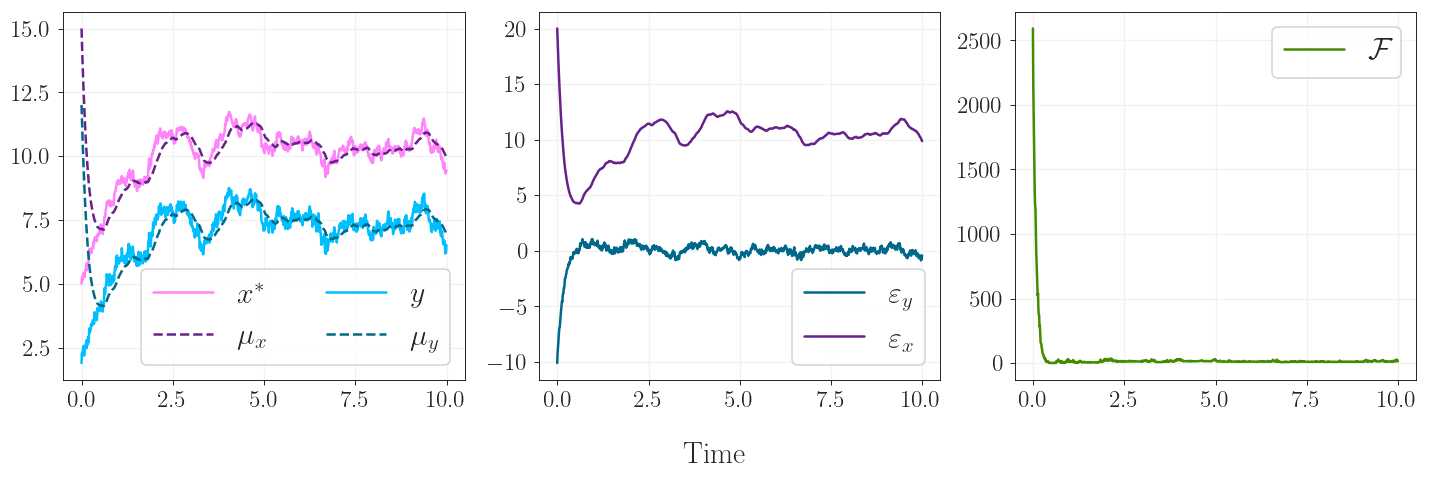

In [122]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, axes = plt.subplots(1,3, facecolor=(1,1,1), figsize=(12,4))

# Left plot
axes[0].plot(t, x, c="#FF83FA", label=r"$x^*$")
axes[0].plot(t, mu_x, c="#68228B", ls="--", lw=1.5, label=r"$\mu_x$")
axes[0].plot(t, y, c="#00BFFF", label=r"$y$")
axes[0].plot(t, mu_y, c="#00688B", ls="--", lw=1.5, label=r"$\mu_y$")

# Middle plot
axes[1].plot(t, e_y, c="#00688B", label=r"$\varepsilon_y$")
axes[1].plot(t, e_x, c="#68228B", label=r"$\varepsilon_x$")

# Left plot
axes[2].plot(t, vfe, c="#458B00", label=r"$\mathcal{F}$")

# Plot labels
fig.supxlabel(r'$\textrm{Time}$', fontsize=18)

# Subplot legends
axes[0].legend(frameon=True, fontsize=18, ncol=2)
axes[1].legend(frameon=True, fontsize=18)
axes[2].legend(frameon=True, fontsize=18)

# Cosmetic changes and axes ranges
for ax in axes.reshape(-1):
    ax.axes.grid(which="major", axis="both", c="#f2f2f2")
    plt.setp(ax.spines.values(), color="black", linewidth=0.5)
    ax.tick_params(
        labelsize=14,
        axis='both',          
        which='major',      
        bottom=True,
        left=True,
        color="black",
        width=0.5,
        length=3)

fig.tight_layout()

In [123]:
fig.savefig("../graphics_v2/6a_gm.pdf", bbox_inches="tight", dpi=300)